In [1]:
import torch
from model import load_resnet_model, register_model_with_hook
from utils import sorted_file_paths
from dataloader import create_dataloader, create_dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
from model import load_resnet_model, register_model_with_hook
from utils import sorted_file_paths
from dataloader import create_dataloader, create_dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.stats import f_oneway

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
test_files = sorted_file_paths('./data/test_records_with_land_cover/test')
test_dataset = create_dataset(test_files, regression = True, half = False)
test_loader = create_dataloader(test_dataset, 64)

In [3]:
model = load_resnet_model('resnet50', num_classes=1)

#statedict = torch.load('./ex_1/checkpoint_epoch_25.pth')
statedict = torch.load('./ex_5/checkpoint_epoch_22.pth')
model.load_state_dict(statedict)
model.eval()
model = model.to(device)

get_feature_maps = register_model_with_hook(model)
fc_weights = model.fc.weight.data

c:\Users\lhmtr\OneDrive\Desktop\remote-sensing-asset-index\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lhmtr\OneDrive\Desktop\remote-sensing-asset-index\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def calculate_G_upsample(feature_map, fc_weights, size=(224, 224)):
    with torch.no_grad():
        weights_reshaped = fc_weights.reshape(-1, 1, 1)  # Ensure correct shape for broadcasting
        weighted_feature_maps = feature_map * weights_reshaped  # Apply weights to each feature map
        G = torch.sum(weighted_feature_maps, dim=1, keepdim=True)  # Sum across the channels        
    # Upsample to the target size and remove the channel dimension
    return F.interpolate(G, size=size, mode='bilinear', align_corners=False).squeeze(1)

def min_max(rgb_image):
    return rgb_image.min(), rgb_image.max()

def image_from_tensor(input_tensor, quarter):
    end_channel = 3*quarter # e.g. 1 => 3, 2 => 6
    begin_channel = end_channel-3
    return input_tensor[0, begin_channel:end_channel, :, :]

def generate_heatmap(image_tensor, max, min, heatmap, alpha=0.4, brightness_factor=1.0):
    # Check the number of channels in the image tensor
    num_channels = image_tensor.size(0)
    
    # Normalize the image tensor to [0, 1]
    normalized_image = (image_tensor - min) / (max - min)
    
    # Convert to numpy array for visualization
    image_np = normalized_image.cpu().numpy().transpose(1, 2, 0)
    
    # If the image has 1 channel, replicate it to 3 channels for a grayscale effect
    if num_channels == 1:
        image_np = np.repeat(image_np, 3, axis=2)
    
    # Brighten the image if needed
    if brightness_factor != 1.0:
        image_np = np.clip(image_np * brightness_factor, 0, 1)

    # Convert the heatmap to an RGBA image
    heatmap_rgba = plt.cm.jet(heatmap.cpu().numpy())  # Apply colormap

    # Display the image with the heatmap overlay
    fig, ax = plt.subplots()
    ax.imshow(image_np, cmap='gray' if num_channels == 1 else None)
    ax.imshow(heatmap_rgba, alpha=alpha)  # Set the transparency
    ax.axis('off')  # Hide axes
    plt.show()

# def meaningful_perturbation(input_tensor, heatmap, num_perturbations=40, neighborhood_size=10):
#     # Convert heatmap to numpy if it's a tensor
#     if isinstance(heatmap, torch.Tensor):
#         heatmap_np = heatmap.cpu().detach().numpy()
#     else:
#         heatmap_np = heatmap

#     # Flatten the heatmap and sort it to identify the most sensitive regions
#     flat_heatmap = heatmap_np.flatten()
#     sorted_indices = np.argsort(flat_heatmap)[::-1]  # Sort in descending order

#     # Copy the input_tensor to perturb
#     if isinstance(input_tensor, torch.Tensor):
#         perturbed_tensor = input_tensor.clone().detach()
#     else:
#         perturbed_tensor = input_tensor.copy()

#     # Replace the pixels in the sorted order with random noise
#     for idx in range(num_perturbations):
#         # Convert flat index to 2D index
#         row, col = np.unravel_index(sorted_indices[idx], heatmap_np.shape)
        
#         # Define the square region to perturb
#         row_start = np.clip(row - neighborhood_size // 2, 0, heatmap_np.shape[0])
#         col_start = np.clip(col - neighborhood_size // 2, 0, heatmap_np.shape[1])
#         row_end = np.clip(row_start + neighborhood_size, 0, heatmap_np.shape[0])
#         col_end = np.clip(col_start + neighborhood_size, 0, heatmap_np.shape[1])

#         # Generate random noise within [0, 1]
#         noise = np.random.uniform(0, 1, (perturbed_tensor.shape[1], neighborhood_size, neighborhood_size))

#         # Apply the noise to the neighborhood region across all channels
#         perturbed_tensor[:, :, row_start:row_end, col_start:col_end] = \
#             torch.from_numpy(noise[:, :row_end-row_start, :col_end-col_start])

#     return perturbed_tensor

In [2]:
# Define category names
category_names = [
    "water", "trees", "grass", "flooded_vegetation", "crops",
    "shrub_and_scrub", "built", "bare", "snow_and_ice"
]

In [6]:
# Initialize dictionaries using category names as keys
category_areas = {name: [] for name in category_names}
average_intensities = {name: [] for name in category_names}
all_labels = []
all_predictions = []

for data, _, labels in test_loader:
    with torch.no_grad():
        data = data.to(device)
        labels = labels.to(device)
        predictions = model(data[:, :24, :, :])

        # Flatten labels and predictions and store
        all_labels.extend(labels.cpu().numpy().flatten())
        all_predictions.extend(predictions.cpu().numpy().flatten())

        feature_map = get_feature_maps(data[:, :24, :, :])
        G_upsampled = calculate_G_upsample(feature_map, fc_weights)

        for i in range(data.size(0)):
            land_cover_mask = data[i, 24, :, :]  # Assuming the land cover mask is at channel index 24

            for idx, category in enumerate(category_names):
                category_mask = (land_cover_mask == idx).float()
                category_area = category_mask.sum().item()
                category_areas[category].append(category_area)

                if category_mask.sum() > 0:
                    average_intensity = (G_upsampled[i] * category_mask).sum() / category_mask.sum()
                    average_intensities[category].append(average_intensity.item())
                else:
                    average_intensities[category].append(np.nan)

# Convert to DataFrames using category names as column labels
intensities_df = pd.DataFrame(average_intensities)
areas_df = pd.DataFrame(category_areas)

# Concatenate the areas DataFrame with the intensities DataFrame
result_df = pd.concat([intensities_df, areas_df.add_suffix("_area")], axis=1)

# Add the labels and predictions as the last columns of the DataFrame
result_df['Label'] = all_labels
result_df['Prediction'] = all_predictions

In [7]:
result_df.to_csv('./analysis/quantitative/model_5.csv')

In [15]:
result_df = pd.read_csv('./analysis/quantitative/model_5.csv')

In [17]:
# Training label
min_label = 0.28095343708992004
max_label = 3.094515085220337

# Define bin edges
bin_edges = np.linspace(min_label, max_label, num= 5+1)  # 5 bins -> 6 edges
bin_edges[0] = -np.inf
bin_edges[5] = np.inf

# Dividing the dataset into wealth index ranges
index_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
result_df['Wealth_Index_Range'] = pd.cut(result_df['Prediction'], bins=bin_edges, labels=index_labels, include_lowest=True)

print(bin_edges)

[      -inf 0.84366577 1.4063781  1.96909043 2.53180276        inf]


In [19]:
# Calculate mean activation intensity for each category
for category in category_names:
    result_df[f'{category}_mean_activation_intensity'] = result_df[category] / result_df[f'{category}_area']

In [20]:
# Calculate average of mean activation intensity for each category within each wealth index range
grouped_means = result_df.groupby('Wealth_Index_Range').mean()[[f'{category}_mean_activation_intensity' for category in category_names]]

C:\Users\lhmtr\AppData\Local\Temp\ipykernel_3980\2713042626.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = result_df.groupby('Wealth_Index_Range').mean()[[f'{category}_mean_activation_intensity' for category in category_names]]


In [21]:
grouped_means

,water_mean_activation_intensity,trees_mean_activation_intensity,grass_mean_activation_intensity,flooded_vegetation_mean_activation_intensity,crops_mean_activation_intensity,shrub_and_scrub_mean_activation_intensity,built_mean_activation_intensity,bare_mean_activation_intensity,snow_and_ice_mean_activation_intensity
Wealth_Index_Range,,,,,,,,,
Very Low,NaN,0.000015,0.024456,0.000674,0.005010,0.000459,-0.000498,NaN,NaN
Low,0.155622,0.000028,0.008611,0.017330,0.014635,0.008684,0.018305,0.247394,0.246398
Medium,0.158316,0.000089,0.024095,0.051534,0.030817,0.018297,0.045355,0.302441,0.235279
High,0.053106,0.001045,0.023859,0.027119,0.006113,0.010358,0.024348,0.228320,0.423524
Very High,0.037567,0.001422,0.018809,0.017686,0.002767,0.008898,0.001408,0.186199,1.009772


In [11]:
print(grouped_means)

                    water_intensity_per_area  trees_intensity_per_area  \
Wealth_Index_Range                                                       
Very Low                                 NaN                  0.000015   
Low                                 0.155622                  0.000028   
Medium                              0.158316                  0.000089   
High                                0.053106                  0.001045   
Very High                           0.037567                  0.001422   

                    grass_intensity_per_area  \
Wealth_Index_Range                             
Very Low                            0.024456   
Low                                 0.008611   
Medium                              0.024095   
High                                0.023859   
Very High                           0.018809   

                    flooded_vegetation_intensity_per_area  \
Wealth_Index_Range                                          
Very Low              

In [14]:
anova_results = {}

for category in category_names:
    # Extract data for each wealth index range
    data_very_low = result_df[result_df['Wealth_Index_Range'] == 'Very Low'][f'{category}_intensity_per_area'].dropna()
    data_low = result_df[result_df['Wealth_Index_Range'] == 'Low'][f'{category}_intensity_per_area'].dropna()
    data_medium = result_df[result_df['Wealth_Index_Range'] == 'Medium'][f'{category}_intensity_per_area'].dropna()
    data_high = result_df[result_df['Wealth_Index_Range'] == 'High'][f'{category}_intensity_per_area'].dropna()
    data_very_high = result_df[result_df['Wealth_Index_Range'] == 'Very High'][f'{category}_intensity_per_area'].dropna()
    
    # Perform one-way ANOVA
    f_stat, p_value = f_oneway(data_low, data_medium, data_high, data_very_high)
    
    # Store the results for each category
    anova_results[category] = {'F-Statistic': f_stat, 'P-Value': p_value}

    # Optionally, print the results for each category
    print(f"ANOVA for {category}:")
    print(f"F-Statistic: {f_stat}, P-Value: {p_value}\n")

ANOVA for water:
F-Statistic: 12.09978354482533, P-Value: 7.667685907355595e-08

ANOVA for trees:
F-Statistic: 12.84327024106259, P-Value: 2.5796515932018185e-08

ANOVA for grass:
F-Statistic: 0.9400380728282809, P-Value: 0.42040268995254726

ANOVA for flooded_vegetation:
F-Statistic: 4.424646198828335, P-Value: 0.004156224043749277

ANOVA for crops:
F-Statistic: 6.68907561023189, P-Value: 0.00017179754278053063

ANOVA for shrub_and_scrub:
F-Statistic: 3.1783498317784593, P-Value: 0.023167438479585828

ANOVA for built:
F-Statistic: 3.475768657346619, P-Value: 0.01543677580756923

ANOVA for bare:
F-Statistic: 2.5106078458428183, P-Value: 0.05721099016556241

ANOVA for snow_and_ice:
F-Statistic: 5.522139143088215, P-Value: 0.0011549644777020444



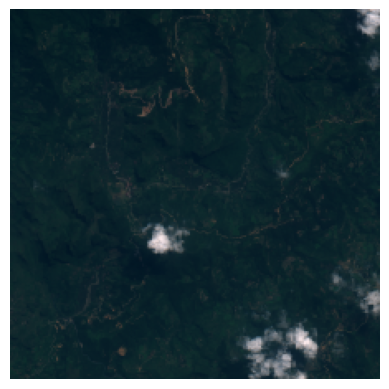

In [113]:
G_zero = torch.zeros((224,224))
image = input_tensor[0,6:9,:,:]
min, max = min_max(image)
generate_heatmap(image, max, min, G_zero, alpha=0, brightness_factor=1)

tensor([[1.2708]])


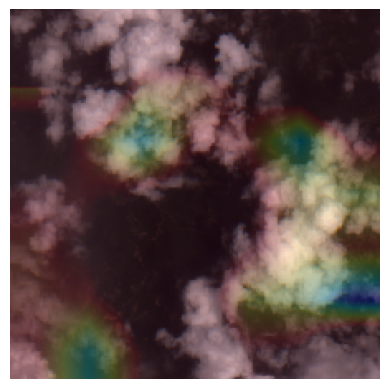

In [133]:
input_tensor = data[0:1,:24,:,:]
with torch.no_grad():
    feature_map = get_feature_maps(input_tensor)
    output = model(input_tensor)

G_upsampled = calculate_G_upsample(feature_map, fc_weights)
image = image_from_tensor(input_tensor, quarter= 2)
min, max = min_max(image)
print(output)

generate_heatmap(image, max, min, G_upsampled, alpha=0.2, brightness_factor=1)

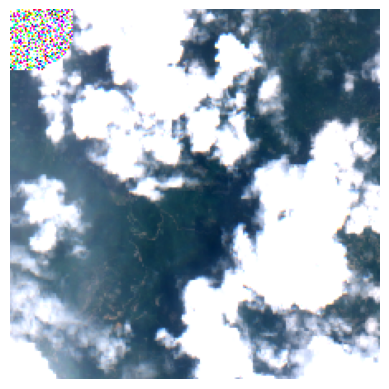

tensor([[1.3337]])
